<h2 style='color:yellow'> About </h2>

<p><i>As the “extinction capital of the world,” Hawai'i has lost 68% of its bird species, the consequences of which can harm entire food chains. Researchers use population monitoring to understand how native birds react to changes in the environment and conservation efforts. But many of the remaining birds across the islands are isolated in difficult-to-access, high-elevation habitats. With physical monitoring difficult, scientists have turned to sound recordings.Known as bioacoustic monitoring, this approach could provide a passive, low labor, and cost-effective strategy for studying endangered bird populations</i></p>

<p><i>In this competition, you’ll use your machine learning skills to identify bird species by sound. Specifically, you'll develop a model that can process continuous audio data and then acoustically recognize the species.If successful, you'll help advance the science of bioacoustics and support ongoing research to protect endangered Hawaiian birds. </i></p>

<a href = https://www.kaggle.com/c/birdclef-2022/overview>Source </a>

<h2 style='color:green'> Some Fantastic Notebooks and Resources </h2>


* https://www.kaggle.com/c/birdclef-2022/discussion/307752
* https://www.kaggle.com/amandanavine/hawaiian-bird-species
* https://www.kaggle.com/c/birdclef-2022/discussion/311005
* https://www.kaggle.com/c/birdclef-2022/discussion/307842
* https://www.tensorflow.org/tutorials/audio/simple_audio
* https://www.kaggle.com/shreyasajal/birdclef-librosa-audio-feature-extraction
* https://www.kaggle.com/kaerunantoka/birdclef2022-create-image-data-from-audio-data
* https://www.kaggle.com/code/virajkadam/birdclef-extracting-spectrograms
* https://earthnworld.com/best-singing-birds-in-the-world/
* http://ceur-ws.org/Vol-1866/paper_143.pdf

<h2 style='color:green'> Imports </h2>

In [1]:
#general
import pandas as pd 
import numpy as np 
import os 

import geopandas as gpd
from shapely import geometry
import geopy 

#plotting
import matplotlib.pyplot as plt 
import seaborn as sns


#deep learning 
import tensorflow as tf 

#mapping
import folium
from folium.plugins import HeatMap,MarkerCluster


#audio data
import librosa
import librosa.display as ld


#colored print 
from termcolor import colored
    
    
from IPython.display import Audio


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


**Helper Functions**

In [2]:
def  color_print(print_str,
                 print_color='green'):
    
    '''print in given  color (default green)'''
    print(colored(print_str,print_color))

    
#helper to plot spectogram
def plot_spectrogram(path,birdname='',sr=None):
    '''plot spectrogram from given path'''
    
    #loading audio
    signal,sr=librosa.load(path,sr=sr)

    fig,ax=plt.subplots(figsize=(16,6))
    M = librosa.feature.melspectrogram(y=signal, sr=sr)
    M_db = librosa.power_to_db(M, ref=np.max)
    img = ld.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
    plt.colorbar(img)
    ax.set(title=f'Mel spectrogram for {birdname}')
    plt.show()

**Setting Random seed**

In [3]:


class config:
    def __init__(self,
                 seed=7):
        self.seed = seed
    
    def set_seed(self):
        '''set seed for reproduciblity'''

        tf.random.set_seed(self.seed)
        os.environ['PYTHONHASHSEED'] = str(self.seed)
        np.random.seed(self.seed)
        color_print(print_str=f'Setting Random Seed  to {self.seed}',
                    print_color='yellow')

        
        
cfg = config(seed=7)
cfg.set_seed()

Setting Random Seed  to 7


# Loading data

In [4]:

train_dir  =  '../input/birdclef-2022/train_audio/' # train audio
test_dir  =  '../input/birdclef-2022/test_soundscapes/'


# csv files 
test = pd.read_csv('../input/birdclef-2022/test.csv')
train_meta = gpd.read_file('../input/birdclef-2022/train_metadata.csv')
train_meta[['latitude','longitude','rating']]=train_meta[['latitude','longitude','rating']].astype(float)

bird_taxanomy = pd.read_csv('../input/birdclef-2022/eBird_Taxonomy_v2021.csv') 

In [5]:
#convert data frame into geo data frame
train_meta.geometry = gpd.points_from_xy(x=train_meta['longitude'],
                                         y = train_meta['latitude'])

#set crs
# train_meta=train_meta.set_crs('epsg:4326')

In [6]:
train_meta.head(2)

primary_label                secondary_labels                     type  \
0       afrsil1                              []  ['call', 'flight call']   
1       afrsil1  ['houspa', 'redava', 'zebdov']                 ['call']   

   latitude  longitude  scientific_name         common_name     author  \
0   12.3910    -1.4930  Euodice cantans  African Silverbill  Bram Piot   
1   19.8801  -155.7254  Euodice cantans  African Silverbill   Dan Lane   

                                             license  rating   time  \
0  Creative Commons Attribution-NonCommercial-Sha...     2.5  08:00   
1  Creative Commons Attribution-NonCommercial-Sha...     3.5  08:30   

                                 url              filename  \
0  https://www.xeno-canto.org/125458  afrsil1/XC125458.ogg   
1  https://www.xeno-canto.org/175522  afrsil1/XC175522.ogg   

                      geometry  
0    POINT (-1.49300 12.39100)  
1  POINT (-155.72540 19.88010)

In [7]:
#adding filepaths to individual files for easy access 

train_meta['filepath'] = train_dir + train_meta.filename

<h2 style= 'color:green'>Audio Exploratory Data Analysis </h2>

<h3 style='color:green'> First lets take a look at some interesting/common bird calls  (click play to play the Audio)</h3>

<h4 style='color:yellow'>Yellow-fronted Canary</h4>

In [8]:
row = train_meta[train_meta['common_name']=='Yellow-fronted Canary'].sort_values(by='rating',ascending=False).iloc[0]
Audio(row['filepath'])

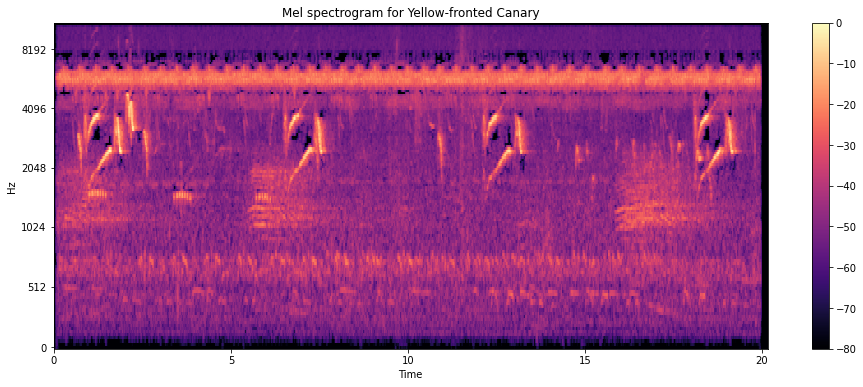

In [9]:
plot_spectrogram(path=row['filepath'],birdname='Yellow-fronted Canary')

<h4 style='color:yellow'>House Sparrow</h4>

In [10]:
row = train_meta[train_meta['common_name']=='House Sparrow'].sort_values(by='rating',ascending=False).iloc[2]
Audio(row['filepath'])

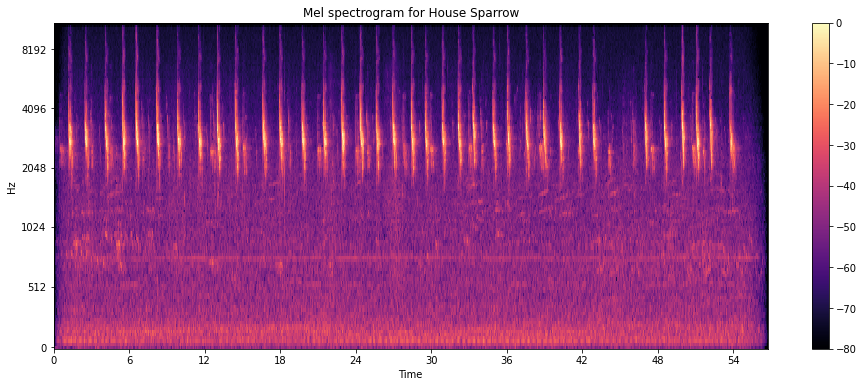

In [11]:
plot_spectrogram(path=row['filepath'],birdname='House Sparrow')

<h4 style='color:yellow'>Barn Owl</h4>

In [12]:
row = train_meta[train_meta['common_name']=='Barn Owl'].sort_values(by='rating',ascending=False).iloc[0]
Audio(row['filepath'])


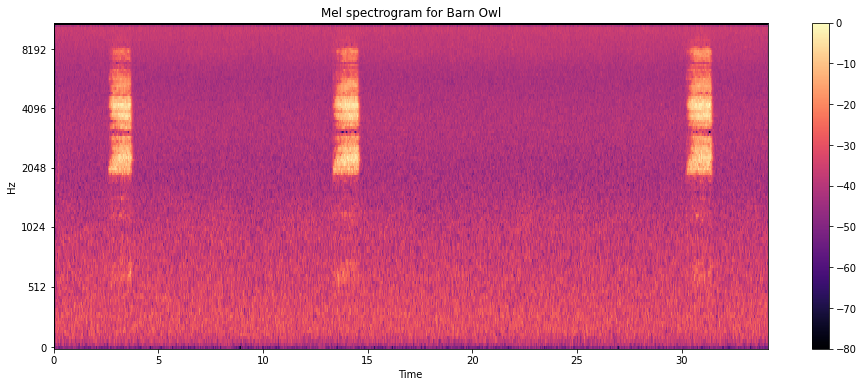

In [13]:
plot_spectrogram(path=row['filepath'],birdname='Barn Owl')

<h4 style='color:yellow'>Indian Peafowl (I hear these calls quite often)</h4>

In [14]:
row = train_meta[train_meta['common_name']=='Indian Peafowl'].sort_values(by='rating',ascending=False).iloc[0]
Audio(row['filepath'])

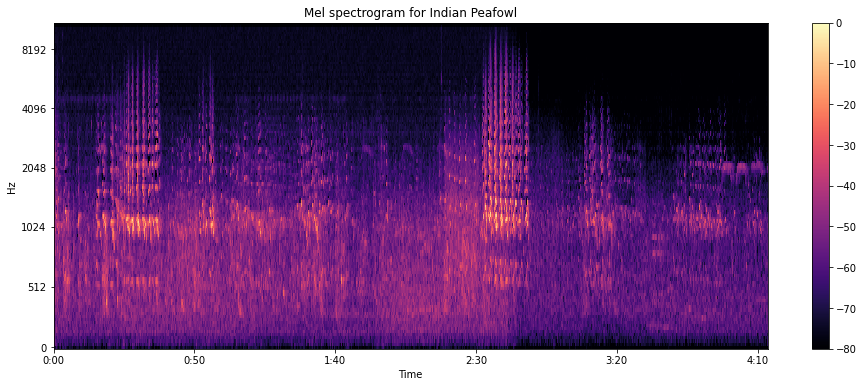

In [15]:
plot_spectrogram(path=row['filepath'],birdname='Indian Peafowl')

<h4 style='color:yellow'>Laughing Gull</h4>

In [16]:
row = train_meta[train_meta['common_name']=='Laughing Gull'].sort_values(by='rating',ascending=False).iloc[0]
Audio(row['filepath'])


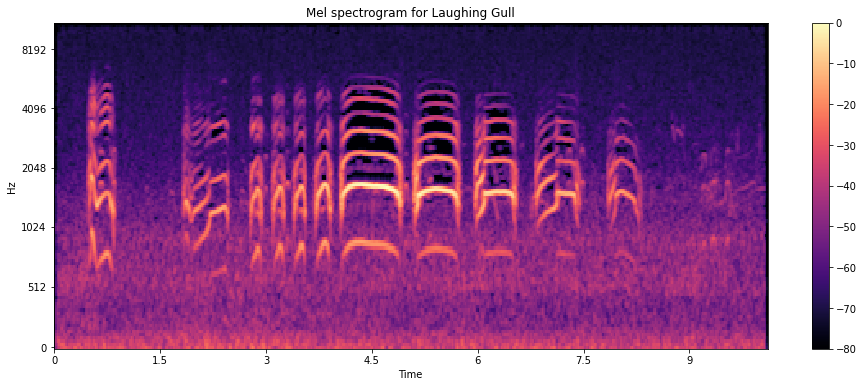

In [17]:
plot_spectrogram(path=row['filepath'],birdname='Laughing Gull')

<h4 style='color:yellow'>Northern Cardinal</h4>

In [18]:
row = train_meta[train_meta['common_name']=='Northern Cardinal'].sort_values(by='rating',ascending=False).iloc[0]
Audio(row['filepath'])


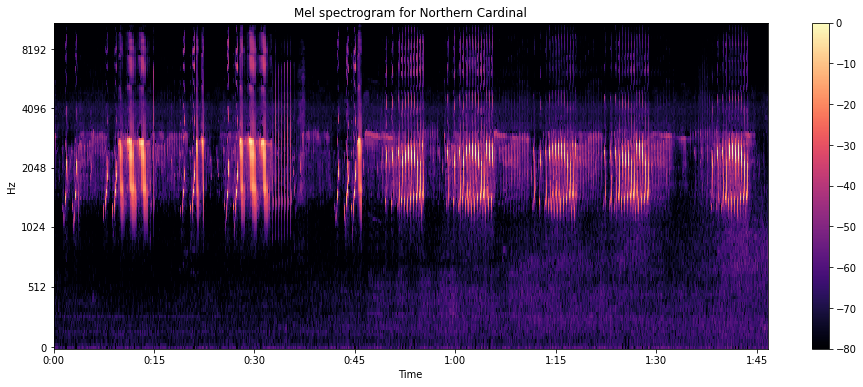

In [19]:
plot_spectrogram(path=row['filepath'],birdname='Northern Cardinal')

<h4 style='color:yellow'>Red Junglefowl</h4>

In [20]:
row = train_meta[train_meta['common_name']=='Red Junglefowl'].sort_values(by='rating',ascending=False).iloc[0]
Audio(row['filepath'])


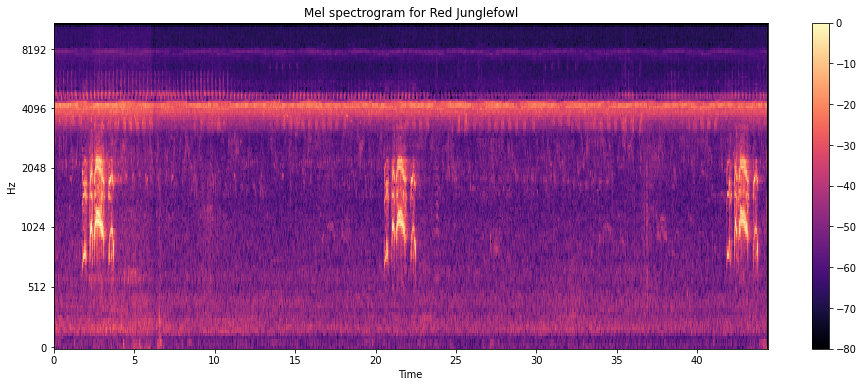

In [21]:
plot_spectrogram(path=row['filepath'],birdname='Red Junglefowl')

<h2 style= 'color:green'>Exploratory Data Analysis </h2>

**A brief look at the Bird Taxanomy data**


![](https://images.theconversation.com/files/176054/original/file-20170628-7313-1au5deb.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1000&fit=clip)

In [22]:
color_print(f'There are {bird_taxanomy.ORDER1.nunique()} unique orders in bird taxanomy data','yellow')
color_print(f'There are {bird_taxanomy.FAMILY.nunique()} unique families in bird taxanomy data','yellow')
color_print(f'There are {bird_taxanomy.SPECIES_CODE.nunique()} unique species in bird taxanomy data','yellow')

There are 41 unique orders in bird taxanomy data
There are 249 unique families in bird taxanomy data
There are 16753 unique species in bird taxanomy data


**Training data**

<h3 style='color:green'> What is the count of ratings of recording quality  ?</h3>

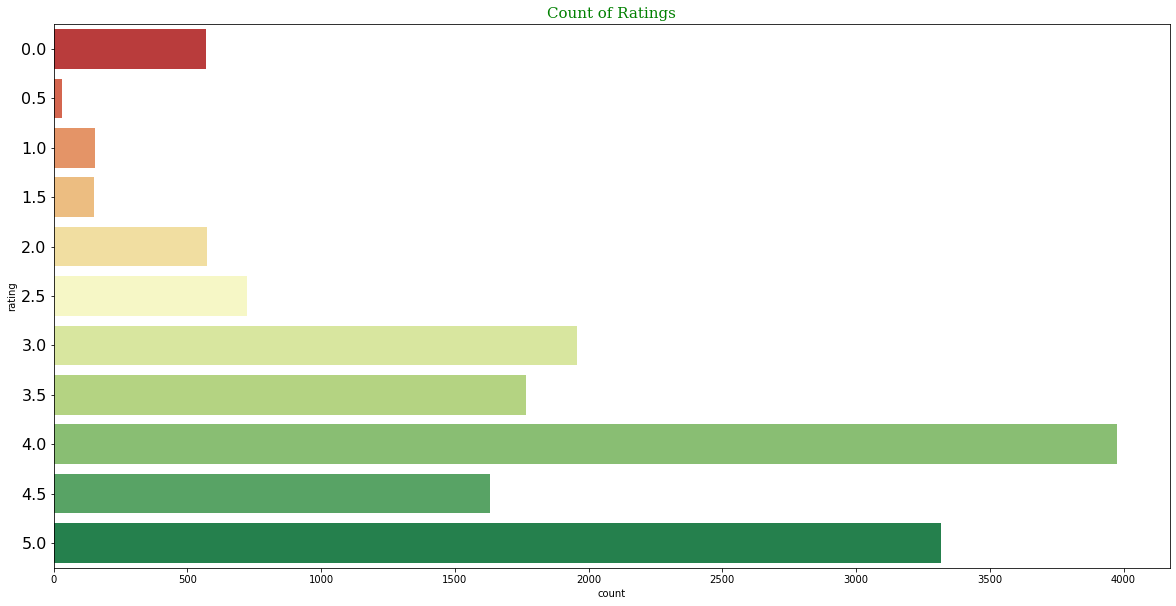

In [23]:
plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
sns.countplot(y="rating",
              data=train_meta,
              palette="RdYlGn",
              linewidth=3)
plt.title("Count of Ratings",font="Serif", size=15,color='g')
plt.show()

In [24]:
color_print(f'There are {train_meta.scientific_name.nunique()} unique species in train data','yellow')
color_print(f'There are {train_meta.shape[0]} recordings in train data','yellow')
print('-'*50 + '.'*30 + '-'*50)
color_print(f'There are {train_meta[train_meta.rating >= 3.5].scientific_name.nunique()} unique species in train data with recording quality rating > 3.5','yellow')
color_print(f'There are {train_meta[train_meta.rating >= 3.5].shape[0]} recordings in train data with recording quality rating > 3.5','yellow')

There are 152 unique species in train data
There are 14852 recordings in train data
--------------------------------------------------..............................--------------------------------------------------
There are 149 unique species in train data with recording quality rating > 3.5
There are 10689 recordings in train data with recording quality rating > 3.5


In [25]:
# taking recordings with rating >3.5 
train_2 = train_meta.query('rating>=3.5')
train_2.shape

(10689, 15)

<h3 style='color:green'> Among the selected recordings, what are the most common type of calls  ?</h3>

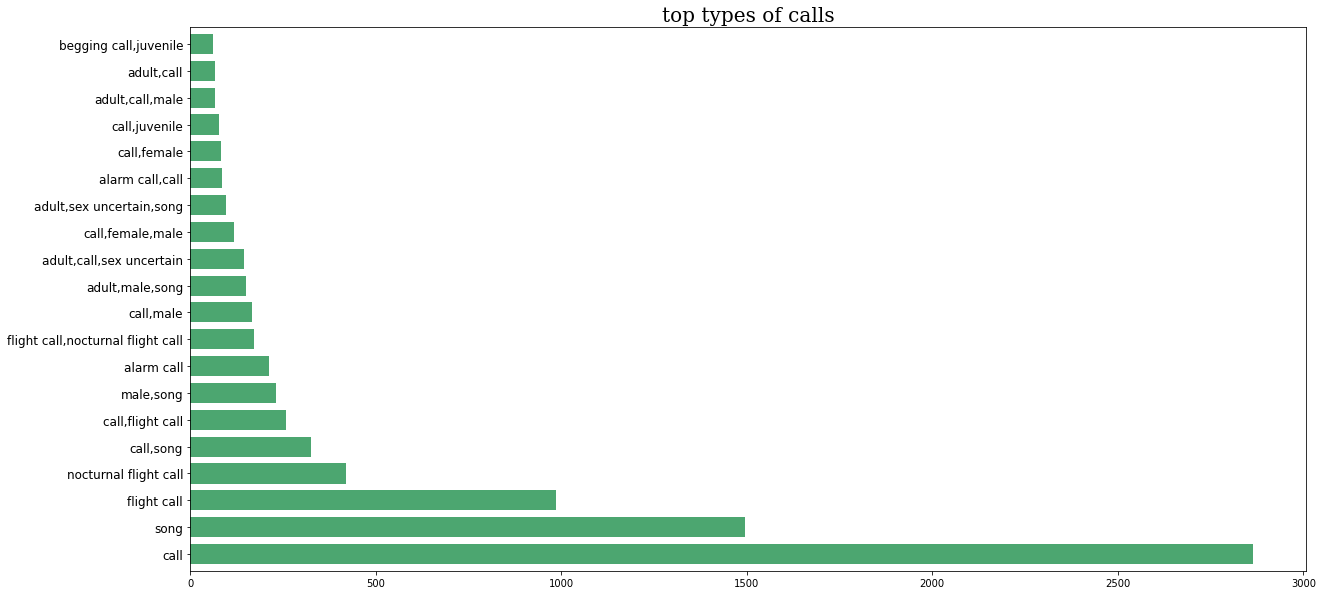

In [26]:
fig=plt.figure(figsize=(20,10))
plt.yticks(fontsize=12)
call_types=pd.Series(train_2['type'].apply(lambda x: ','.join(eval(x)))).value_counts().sort_values(ascending=False)[:20]

call_types.plot.barh(title = 'top types of call',color=(0,0.5,0.2,0.7),width = 0.75)
plt.title("top types of calls",font="Serif", size=20)

plt.show()

<h3 style='color:green'> Among the selected recordings, which are the most recorded birds ?</h3>

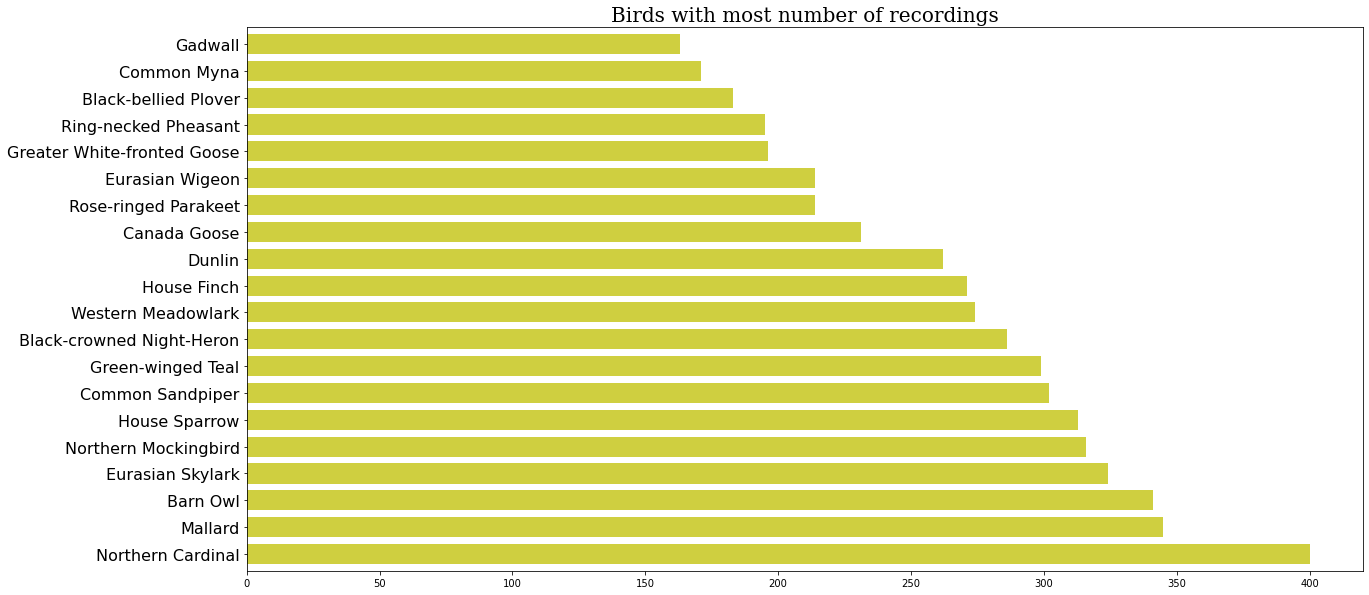

In [27]:
fig=plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
top_birds=train_2['common_name'].value_counts().sort_values(ascending=False)[:20]
plt.title("Birds with most number of recordings",font="Serif", size=20)

top_birds.plot.barh(color= 'y',width = 0.75,alpha=0.75)

plt.show()

<h3 style='color:green'> Among the selected recordings, which are the least recorded birds ?</h3>

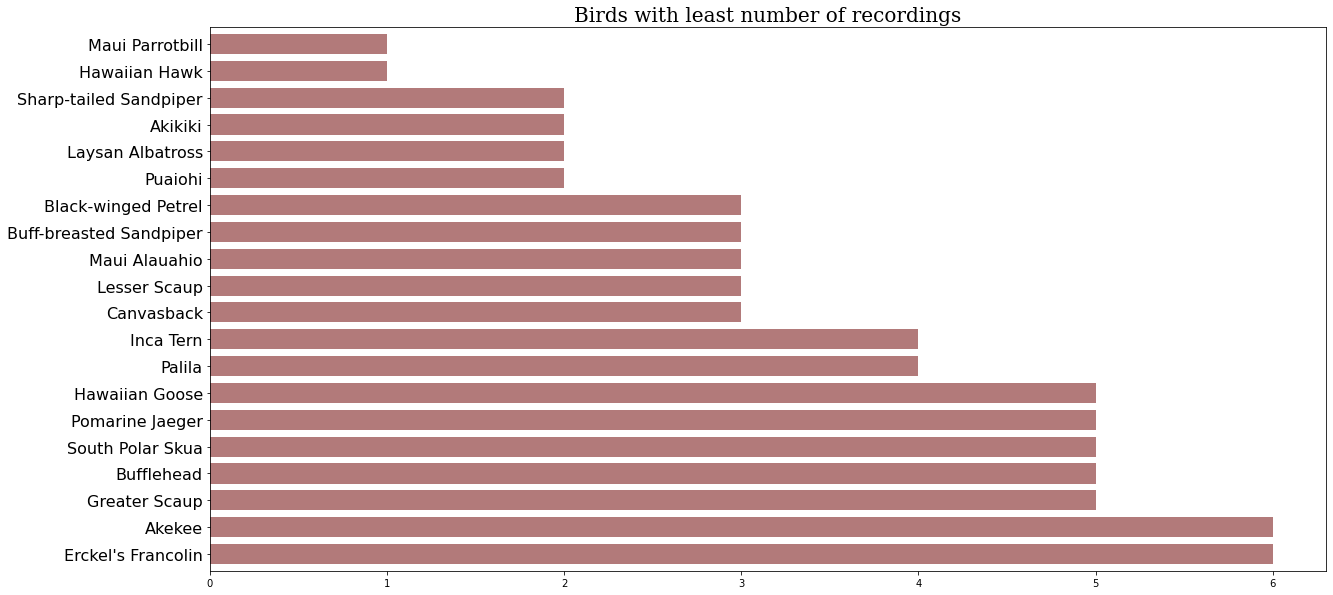

In [28]:
fig=plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)

rare_birds=train_2['common_name'].value_counts().sort_values(ascending=True)[:20]

rare_birds.sort_values(ascending=False).plot.barh(title = 'Birds with least number of recordings',color= (0.6,0.3,0.3,0.75),width = 0.75)
plt.title("Birds with least number of recordings",font="Serif", size=20)

plt.show()

<h3 style='color:green'> Who are the most common contributors ?</h3>

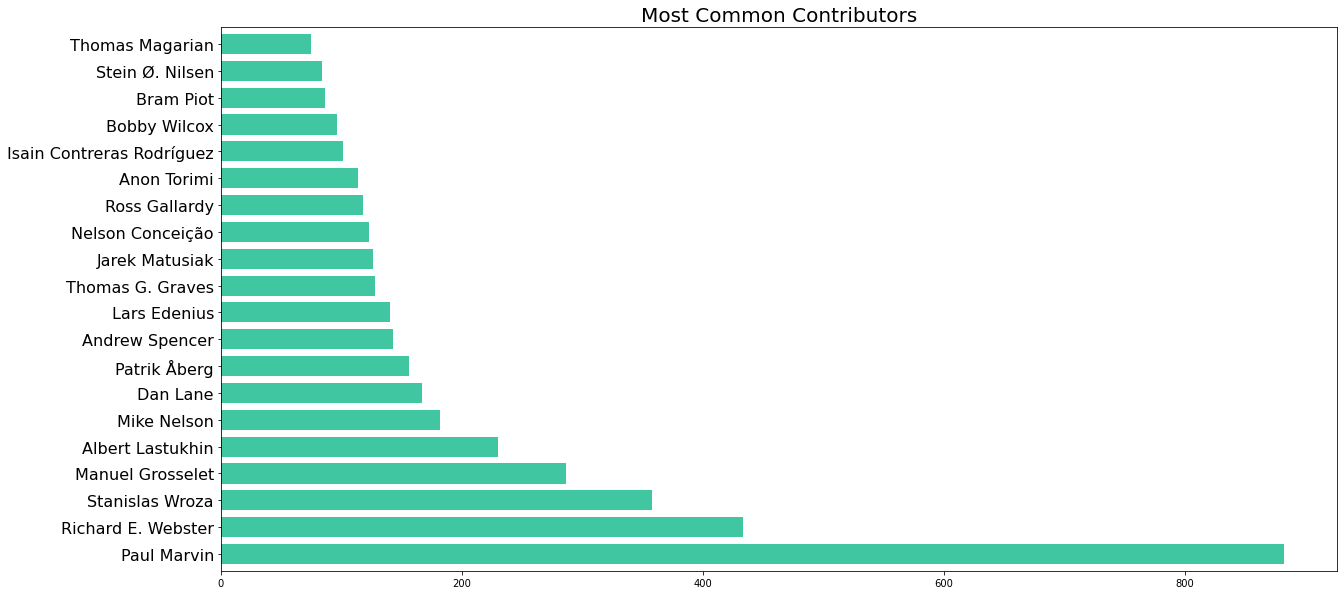

In [29]:
fig=plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
top_aut=train_2['author'].value_counts().sort_values(ascending=False)[:20]
top_aut.plot.barh(color= (0.0,0.7,0.5,0.75),width = 0.75)
plt.title("Most Common Contributors",color='k', size=20)

plt.show()

<h3 style='color:green'> Where are the birds audio recorded at ?</h3>

In [30]:
m1 = folium.Map(location=(train_meta.latitude.mean(),train_meta.longitude.mean()),zoom_start = 4, min_zoom=3,max_zoom=7)
h_map = HeatMap(data=train_meta[['latitude','longitude']],
                radius=4,
                blur=2).add_to(m1)

m1

<h3 style='color:green'> What are the birds found in hawai'i ?</h3>

In [31]:
lat,lon  = 19.741755, -155.844437


#take a buffer region around defined location
hawaii_location = geometry.Point([lon,lat]).buffer(3)

hawaii_birds = train_meta[train_meta.geometry.intersects(hawaii_location)]

color_print(f'There are {hawaii_birds.size} birds recordings from Hawaii and surrounding region.','yellow')
color_print(f'There are {hawaii_birds.common_name.nunique()} unique birds from Hawaii and surrounding region.','yellow')

There are 4800 birds recordings from Hawaii and surrounding region.
There are 49 unique birds from Hawaii and surrounding region.


<h3 style='color:green'> Lets see a map of recordings in hawaii. Hover over the dots to see the common name of the birds</h3>

In [32]:
#map
m2 = folium.Map(location=(lat,lon),zoom_start = 7, min_zoom=6,max_zoom=14)

hawaii_birds.explore(m=m2,tiles= 'OpenStreetMap',tooltip='common_name')

m2

<h3 style='color:green'> What is the distribution of birds found in Hawai'i ?</h3>

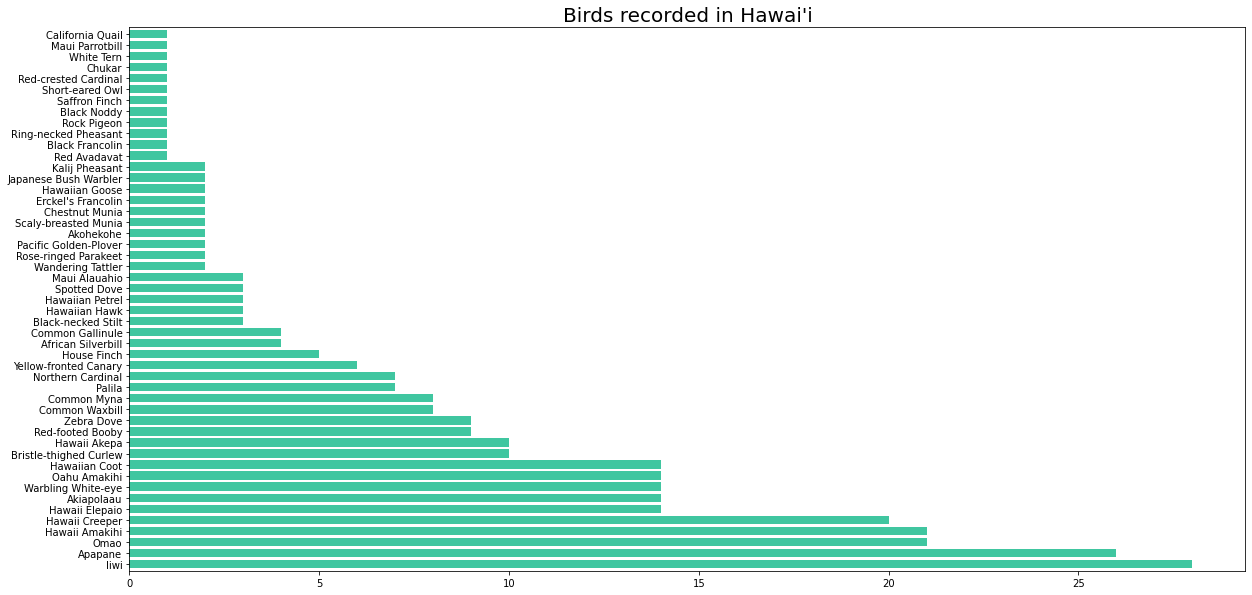

In [33]:
fig=plt.figure(figsize=(20,10))
plt.yticks(fontsize=16)
hawaii_birds.common_name.value_counts().plot.barh(color= (0.0,0.7,0.5,0.75),width = 0.75)
plt.title("Birds recorded in Hawai'i",color='k', size=20)
plt.yticks(size=10)

plt.show()